In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)
random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = 10
eps_sublevels = percents = [0.1, 0.01]

alpha = 1 # proximal term coefficient

num_agents = num_commodities = 100

filename = "mcf_N%d_%s_n%d"%(num_points, ",".join(list(map(str, eps_sublevels))), num_agents)

In [4]:
num_vertices = 15
num_edges = 100

params, A_ineq, b_ineq = mra.mcf_data(num_vertices, num_edges, num_commodities)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_x, true_f, true_lamb = mra.centralized_multi_commodity_flow(params, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-127.24864071521705


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.9999999999761228

In [7]:
true_lamb.shape, true_x.shape

((100, 1), (10000, 1))

In [8]:
fun_agents_eps = {}
fun_agents_noisy_y = {}
for eps in percents:
    fun_agents_eps[eps] = []
    fun_agents_noisy_y[eps] = []
    for i in range(num_agents):
        fun_agents_eps[eps] += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions(lamb_k, i, params[i], 
                                                                           eps_sublevel=eps, K=K, return_best=True)]
        fun_agents_noisy_y[eps] += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions_noisy_prices(lamb_k, i, params[i], percent=eps, K=K)]


fun_obj_val = lambda x_k: mra.mcf_obj_value(x_k, params)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [10]:
A_ineq.shape, params[0]["upper_bound"].shape, num_edges

((100, 10000), (100, 1), 100)

In [ ]:
all_results_eps = {}
all_results_noisy_y = {}
for eps in percents[::-1]:
    print(f"{eps=}")
    all_results_eps[eps]  = mra.price_localization_primal_recovery(fun_agents_eps[eps], fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[eps]  = mra.price_localization_primal_recovery(fun_agents_noisy_y[eps], fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

In [13]:
eps = max(percents)
if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
    all_res = all_results_noisy_y[eps]
else:
    all_res = all_results_eps[eps]

In [15]:
for i, eps in enumerate(percents):
      print(np.array(all_res["viol_primal_xk"])[-1] / b_norm,
      "sub_eps", np.array(all_results_eps[eps]["viol_primal_mra_xk"])[-1] / b_norm,
      "noisy_y", np.array(all_results_noisy_y[eps]["viol_primal_mra_xk"])[-1] / b_norm)

1.0054247232538476 sub_eps 0.8124399127674259 noisy_y 4.308234538912443e-07
1.0054247232538476 sub_eps 0.65866751181934 noisy_y 0.4190374376070961


In [ ]:
import pickle

with open(f"results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle

# with open(f"results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    eps = max(percents)
    if len(all_results_noisy_y[eps]["subopt_xk"]) > len(all_results_eps[eps]["subopt_xk"]):
        all_res = all_results_noisy_y[eps]
    else:
        all_res = all_results_eps[eps]
# res["eps"].keys()

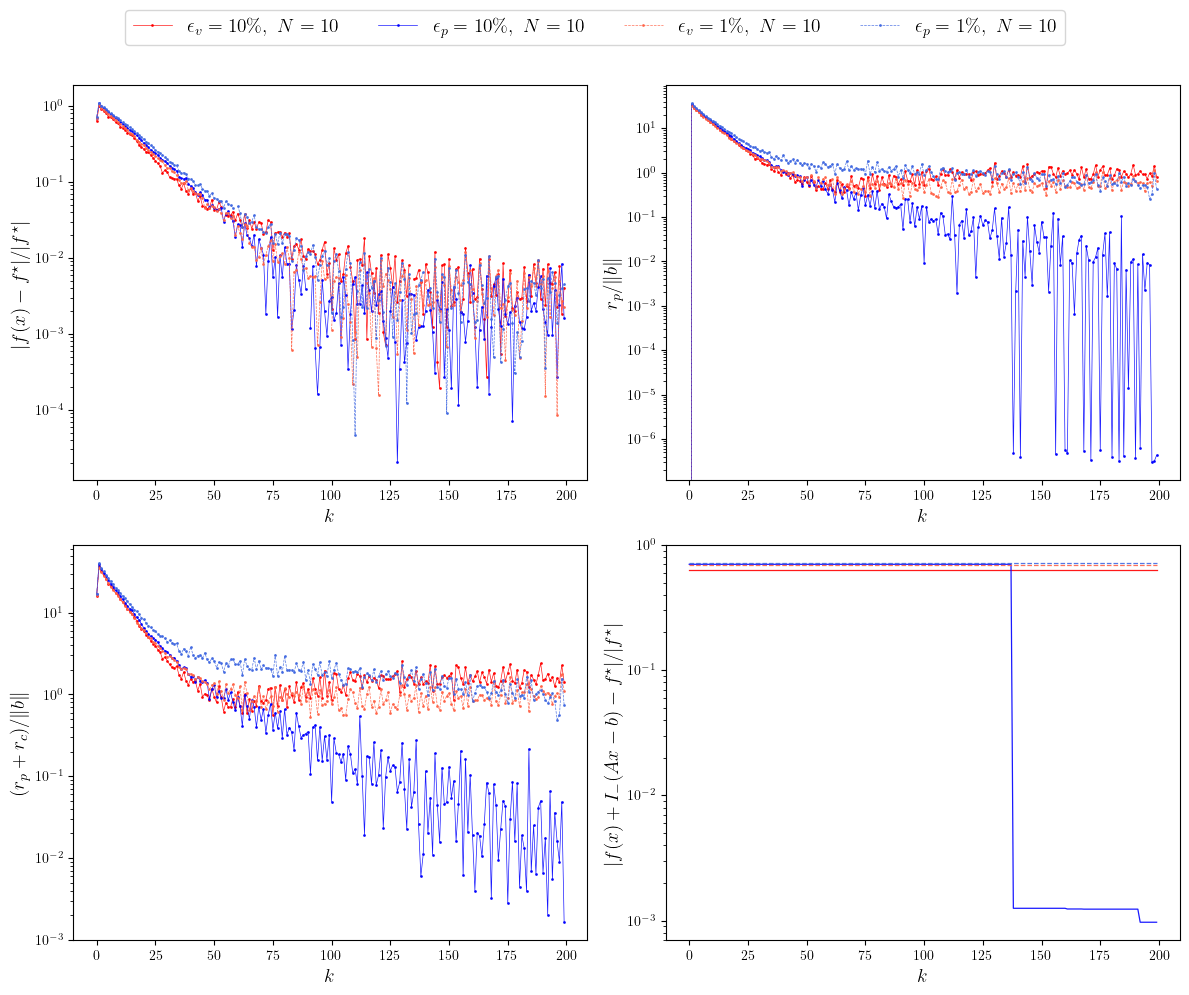

In [8]:
mra.plot_eps_all_metrics_4x(all_results_eps, all_results_noisy_y, num_points, true_f, b_norm, percents, filename)